In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np

In [2]:
# Importing the dataset 
weather = pd.read_csv("../data/weather/weather.csv")
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

### Missing Values 

In [3]:
def determine_column_counts(weather):
    columns = weather.columns
    data_counts = pd.DataFrame(columns = ['column_name','column_type','num_rows','distinct_data', 'distinct_percent', 'missing_data', 'missing_percentage'])
    
    #For each column, calculate number and percentage of missing rows and distinct counts
    for col in columns:
        col_vals = weather[col]
        total_data = len(col_vals)
        col_missing = sum(col_vals.isnull())
        missing_percent = round((col_missing / len(weather[col])) * 100 , 3)
        col_distinct = (col_vals.nunique())
        distinct_percent = round((col_distinct / len(weather[col])) * 100 , 3)

        data_counts.loc[len(data_counts)] = [col, col_vals.dtype, total_data, col_distinct, distinct_percent, col_missing, missing_percent]
        
    return(data_counts)

missing_data = determine_column_counts(weather)
missing_data

,column_name,column_type,num_rows,distinct_data,distinct_percent,missing_data,missing_percentage
0,timestamp,datetime64[ns],331166,17544,5.298,0,0.000
1,site_id,object,331166,19,0.006,0,0.000
2,airTemperature,float64,331166,646,0.195,128,0.039
3,cloudCoverage,float64,331166,10,0.003,170987,51.632
4,dewTemperature,float64,331166,553,0.167,328,0.099
5,precipDepth1HR,float64,331166,167,0.050,133186,40.217
6,precipDepth6HR,float64,331166,168,0.051,313004,94.516
7,seaLvlPressure,float64,331166,756,0.228,21624,6.530
8,windDirection,float64,331166,59,0.018,13005,3.927
9,windSpeed,float64,331166,73,0.022,574,0.173


### Drop columns that will not be used in our model

In [4]:
# Drop columns which are not relevant to the analysis
weather = weather.drop(['dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'cloudCoverage', 'windSpeed'], axis=1)

In [5]:
determine_column_counts(weather)    

,column_name,column_type,num_rows,distinct_data,distinct_percent,missing_data,missing_percentage
0,timestamp,datetime64[ns],331166,17544,5.298,0,0.000
1,site_id,object,331166,19,0.006,0,0.000
2,airTemperature,float64,331166,646,0.195,128,0.039


Before we imputute we will split the data into test and train (2016 and 2017 respectively) since we must impute 2017 values based on historical values

### Add season field

In [6]:
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Define the function for determining seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Apply the season function to create a 'season' column
weather['season'] = weather['timestamp'].dt.month.apply(get_season)

# Split the data into 2016 and 2017
weather_2016 = weather[weather['timestamp'].dt.year == 2016]
weather_2017 = weather[weather['timestamp'].dt.year == 2017]

# List of columns to impute
weather_columns = [
    'airTemperature'
]

# Calculate seasonal means from 2016 data
seasonal_means_2016 = {column: weather_2016.groupby('season')[column].mean() for column in weather_columns}

# Function to impute missing values using the seasonal means
def impute_with_seasonal_means(df, seasonal_means):
    for column, means in seasonal_means.items():
        for season, mean in means.items():
            df.loc[(df['season'] == season) & (df[column].isnull()), column] = mean
    return df

# Impute missing values in both datasets
weather_2016_imputed = impute_with_seasonal_means(weather_2016.copy(), seasonal_means_2016)
weather_2017_imputed = impute_with_seasonal_means(weather_2017.copy(), seasonal_means_2016)

# Combine the datasets back into one:
weather_imputed = pd.concat([weather_2016_imputed, weather_2017_imputed], ignore_index=True)

# Show the head of the imputed dataset
weather_imputed.head()

,timestamp,site_id,airTemperature,season
0,2016-01-01 00:00:00,Panther,19.4,Winter
1,2016-01-01 01:00:00,Panther,21.1,Winter
2,2016-01-01 02:00:00,Panther,21.1,Winter
3,2016-01-01 03:00:00,Panther,20.6,Winter
4,2016-01-01 04:00:00,Panther,21.1,Winter


In [7]:
# Confirming we have imputed the values correctly  
determine_column_counts(weather_imputed)

,column_name,column_type,num_rows,distinct_data,distinct_percent,missing_data,missing_percentage
0,timestamp,datetime64[ns],331166,17544,5.298,0,0.0
1,site_id,object,331166,19,0.006,0,0.0
2,airTemperature,float64,331166,650,0.196,0,0.0
3,season,object,331166,4,0.001,0,0.0


In [8]:
# Aggregating weather daily 
weather_imputed['timestamp'] = pd.to_datetime(weather_imputed['timestamp'])
weather_imputed['date'] = weather_imputed['timestamp'].dt.date

numeric_cols = weather_imputed.select_dtypes(include=['number']).columns
non_numeric_cols = weather_imputed.select_dtypes(exclude=['number', 'datetime64']).columns

# Aggregate the numeric columns by day
numeric_daily_avg = weather_imputed.groupby('date')[numeric_cols].mean()

# Merge the aggregated numeric DataFrame with the non-numeric columns
daily_avg = pd.merge(numeric_daily_avg, weather_imputed[non_numeric_cols].drop_duplicates(), on='date')

In [9]:
# check the daily data for one specific site
daily_avg[daily_avg['site_id'] == 'Wolf']

,date,airTemperature,site_id,season
14,2016-01-01,5.246861,Wolf,Winter
33,2016-01-02,5.993973,Wolf,Winter
52,2016-01-03,5.660314,Wolf,Winter
71,2016-01-04,5.048507,Wolf,Winter
90,2016-01-05,4.745567,Wolf,Winter
...,...,...,...,...
13788,2017-12-27,0.148770,Wolf,Winter
13807,2017-12-28,-0.844098,Wolf,Winter
13826,2017-12-29,0.168282,Wolf,Winter
13845,2017-12-30,1.567716,Wolf,Winter


In [10]:
daily_avg['airTemperature'].describe()  

count    13869.000000
mean        14.220595
std          6.673515
min         -0.844098
25%          8.112939
50%         14.369956
75%         20.664254
max         25.487445
Name: airTemperature, dtype: float64

Checking to make sure we have the correct number of rows for each site id

### Visualize the temperature distribution over time

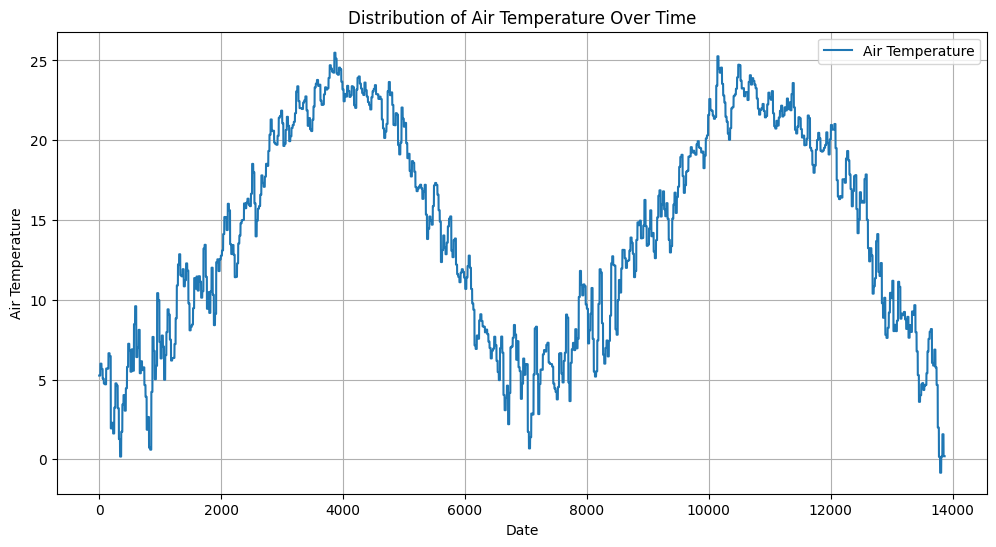

In [11]:
import matplotlib.pyplot as plt

# Assuming daily_avg is your DataFrame and it has a DateTime index
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg['airTemperature'], label='Air Temperature')
plt.xlabel('Date')
plt.ylabel('Air Temperature')
plt.title('Distribution of Air Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Combined weather data with building and meters data

In [12]:
# Combining with meter-meta-data
meter_meta = pd.read_csv("../data/cleaned/cleaned_meters_meta.csv", index_col=0)

In [13]:
#Convert 'date' columns to datetime
meter_meta['date'] = pd.to_datetime(meter_meta['date'])
daily_avg['date'] = pd.to_datetime(daily_avg['date'])

# Ensure 'site_id' columns are the same type
meter_meta['site_id'] = meter_meta['site_id'].astype(str)
daily_avg['site_id'] = daily_avg['site_id'].astype(str)

# Remove any potential leading/trailing spaces
meter_meta['site_id'] = meter_meta['site_id'].str.strip()
daily_avg['site_id'] = daily_avg['site_id'].str.strip()

# Perform the merge again
merged_df = pd.merge(meter_meta, daily_avg, on=['site_id', 'date'], how='left')

### Add features of month to the dataframe

In [14]:
merged_df["month"] = merged_df["date"].dt.month
merged_df["weekday"] = merged_df["date"].dt.weekday

In [15]:
# Drop rows where 'airTemperature' is null
merged_df = merged_df.dropna(subset=['airTemperature'])

In [16]:
merged_df.head()

,building_id,meter,date,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,timezone,airTemperature,season,month,weekday
0,Bear_education_Alfredo,electricity,2016-01-01,2.9050,Bear,Education,Education,609.8,6564.0,US/Pacific,5.246861,Winter,1,4
1,Bear_education_Alfredo,electricity,2016-01-02,2.7700,Bear,Education,Education,609.8,6564.0,US/Pacific,5.993973,Winter,1,5
2,Bear_education_Alfredo,electricity,2016-01-03,2.6725,Bear,Education,Education,609.8,6564.0,US/Pacific,5.660314,Winter,1,6
3,Bear_education_Alfredo,electricity,2016-01-04,4.5650,Bear,Education,Education,609.8,6564.0,US/Pacific,5.048507,Winter,1,0
4,Bear_education_Alfredo,electricity,2016-01-05,4.7825,Bear,Education,Education,609.8,6564.0,US/Pacific,4.745567,Winter,1,1


### Check missing values

In [17]:
determine_column_counts(merged_df)  

,column_name,column_type,num_rows,distinct_data,distinct_percent,missing_data,missing_percentage
0,building_id,object,1342998,924,0.069,0,0.0
1,meter,object,1342998,8,0.001,0,0.0
2,date,datetime64[ns],1342998,731,0.054,0,0.0
3,meter_reading,float64,1342998,873658,65.053,0,0.0
4,site_id,object,1342998,17,0.001,0,0.0
5,primaryspaceusage,object,1342998,2,0.000,0,0.0
6,sub_primaryspaceusage,object,1342998,15,0.001,0,0.0
7,sqm,float64,1342998,906,0.067,0,0.0
8,sqft,float64,1342998,906,0.067,0,0.0
9,timezone,object,1342998,6,0.000,0,0.0


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1342998 entries, 0 to 1343577
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   building_id            1342998 non-null  object        
 1   meter                  1342998 non-null  object        
 2   date                   1342998 non-null  datetime64[ns]
 3   meter_reading          1342998 non-null  float64       
 4   site_id                1342998 non-null  object        
 5   primaryspaceusage      1342998 non-null  object        
 6   sub_primaryspaceusage  1342998 non-null  object        
 7   sqm                    1342998 non-null  float64       
 8   sqft                   1342998 non-null  float64       
 9   timezone               1342998 non-null  object        
 10  airTemperature         1342998 non-null  float64       
 11  season                 1342998 non-null  object        
 12  month                  1342998 no

In [19]:
merged_df.to_csv("../data/cleaned/cleaned_all_data.csv")

In [20]:
import gc
gc.collect()    

0